In [1]:
#IPython extension to reload modules before executing user code.
#'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

#select the best free GPU on the nvidia card
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
bestGPU = 1

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

'''
#set memory usage to 0.5
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
set_session(tf.Session(config=config))'''

setGPU: Setting GPU to: 1


'\n#set memory usage to 0.5\nfrom keras.backend.tensorflow_backend import set_session\nimport tensorflow as tf\nconfig = tf.ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.33\nset_session(tf.Session(config=config))'

In [3]:
#!pip install -q sklearn
import collections
import numpy as np, numpy
from keract import get_activations, display_activations
import keras
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10, cifar100 # we can use also cifar100
from keras.layers import Input, BatchNormalization, AveragePooling2D, ZeroPadding2D, LeakyReLU, GlobalAveragePooling2D, Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, Model
from keras.regularizers import l2
from keras.utils import plot_model, to_categorical
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import scipy
import sklearn
import sklearn.metrics
import sys
#sys.executable
#sys.path
import time
from IPython.display import SVG

Using TensorFlow backend.


In [4]:
def normalize(x, mean, std):
    # This function normalizes inputs for zero mean and unit variance to speed up learning.
    
    # In case std = 0, we add eps = 1e-7
    eps = K.epsilon()
    x = (x-mean)/(std+eps)
    return x
  
def import_cifar(dataset):
    if dataset == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    elif dataset == 100:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

    # By default, they are uint8 but we need them float to normalize them
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    # Calculating the mean and standard deviation of the training data
    mean = np.mean(x_train, axis=(0, 1, 2, 3))
    std = np.std(x_train, axis=(0, 1, 2, 3))
    
    # Normalizing 
    x_train = normalize(x_train, mean, std)
    x_test = normalize(x_test, mean, std)

    y_train = to_categorical(y_train, num_classes=dataset)
    y_test = to_categorical(y_test,  num_classes=dataset)
    
    return (x_train, y_train), (x_test, y_test)

In [5]:
# LOAD DATABase
num_classes = 10
(x_train, y_train), (x_test, y_test) = import_cifar(num_classes)

In [6]:
# Architecture taken from https://github.com/geifmany/cifar-vgg
# Weight decay and Dropout have been removed
# BatchNormalization before activations
def VGG16_Vanilla_beta(input_shape, num_classes):
    model = Sequential([
        #0
        Conv2D(64, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #3
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #7
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #10
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #14
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #17
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #20
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #24
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #27
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #30
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #34
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #37
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #40
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        #45
        Dense(512),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #48
        Dense(num_classes),
        BatchNormalization(scale=False, center=False),
        Activation('softmax')])
    return model

# Architecture taken from https://github.com/geifmany/cifar-vgg
# BatchNormalization before activations
def VGG16_beta(input_shape, num_classes, weight_decay):
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', input_shape=input_shape, kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.3),
        Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.4),
        Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.4),
        Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.4),
        Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.4),
        Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.4),
        Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.4),
        Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.4),
        Conv2D(512, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #Dropout(0.5),
        Flatten(),
        Dense(512, kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #Dropout(0.5),
        Dense(num_classes, kernel_regularizer=regularizers.l2(weight_decay)),
        BatchNormalization(scale=False, center=False),
        Activation('softmax')])
    return model

In [7]:
#model_name = 'modelLAY_65.49%test_94%train_epoch50_0012lr.hdf5'
#model_name = 'modelLAY_75.47%test_87.42%train_epoch50_0018lr.hdf5'
#model_name = 'modelLAY_80.85%test_96.694%train_epoch50_0008lr'
#model_name = 'modelSGD_71.7%test_100%train_epoch21_0.002lr'
#model_name = 'modelSGD_76.67%test_100%train_epoch39_0.004lr'
#model_name = 'modelSGD_80.92%test_99.994%train_epoch50_0.008lr'
#model_name = 'modelWD_63.63%test_91.126%train_epoch50_0.014lr_0005'
#model_name = 'modelWD_75.58%test_97.606%train_epoch50_0.002lr_0005'
#model_name = 'modelWD_76.06%test_94.556%train_epoch50_0.008lr_0005'

modelename = 'vgg16_layca_0'
#layca, sgd, wdecay
model_name = '../weights/4/{}/final/weights-final.hdf5'.format(modelename)

In [8]:
# LOAD MODEL SDG/LAYCA or WD
model = VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10)
#model = VGG16_beta(input_shape=(32,32,3), num_classes=10, weight_decay=0.005)

#model.load_weights('weights/{}.hdf5'.format(model_name))
model.load_weights('{}'.format(model_name))

sgd = optimizers.SGD(lr=0.002, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [9]:
# EVALUATION
# Final evaluation of the models
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print("%.2f%% : Model Error" % (100-scores[1]*100))

10000/10000 [==============================] - 4s 375us/step
Test loss: 1.2308782379150391
Test accuracy: 0.651
34.90% : Model Error


# CLUSTERING

In [10]:
# On regarde l'activation des pairs de neurones pour un echantillon test pris au hasard
Echantillon = []
nombreDImagesDActivation = 1000
choix = np.random.choice(x_test.shape[0], nombreDImagesDActivation)
Echantillon = x_train[choix, :, : , :]

IM = get_activations(model, Echantillon)
# on affiche les noms des differentes couches
print(IM.keys())
model.summary()

dict_keys(['conv2d_7/BiasAdd:0', 'activation_15/Softmax:0', 'batch_normalization_7/cond/Merge:0', 'batch_normalization_1/cond/Merge:0', 'activation_13/Relu:0', 'conv2d_10/BiasAdd:0', 'batch_normalization_9/cond/Merge:0', 'activation_1/Relu:0', 'max_pooling2d_5/MaxPool:0', 'activation_10/Relu:0', 'conv2d_9/BiasAdd:0', 'activation_5/Relu:0', 'batch_normalization_5/cond/Merge:0', 'activation_3/Relu:0', 'activation_7/Relu:0', 'activation_9/Relu:0', 'conv2d_4/BiasAdd:0', 'activation_12/Relu:0', 'conv2d_13/BiasAdd:0', 'conv2d_12/BiasAdd:0', 'batch_normalization_2/cond/Merge:0', 'activation_11/Relu:0', 'activation_2/Relu:0', 'batch_normalization_3/cond/Merge:0', 'activation_8/Relu:0', 'conv2d_1/BiasAdd:0', 'max_pooling2d_2/MaxPool:0', 'batch_normalization_10/cond/Merge:0', 'conv2d_11/BiasAdd:0', 'conv2d_8/BiasAdd:0', 'activation_6/Relu:0', 'batch_normalization_15/cond/Merge:0', 'batch_normalization_8/cond/Merge:0', 'max_pooling2d_1/MaxPool:0', 'activation_4/Relu:0', 'conv2d_5/BiasAdd:0', 'max

In [11]:
# Here we take 100% of the cluster (could take less if the clusters are more)
# we suppose k = 2 (?!)
# DO : ratio in SilhouetteScore
# SEE LATER...

def AverageDistance(vecteur,vecteurs_without_vecteur):
    nCluster_i = len(vecteurs_without_vecteur)
    distance = 0
    for vect in vecteurs_without_vecteur:
        #distance = distance + scipy.spatial.distance.euclidean(vecteur,vect)
        distance = distance + numpy.linalg.norm(vecteur-vect)
    a = (1/(nCluster_i))*distance
    return a

def AverageDissimilarity(vecteur, vecteurs_from_another_cluster):
    nCluster_j = len(vecteurs_from_another_cluster)
    distance = 0
    for vect in vecteurs_from_another_cluster:
        #distance = distance + scipy.spatial.distance.euclidean(vecteur,vect)
        distance = distance + numpy.linalg.norm(vecteur-vect)
    b = (1/nCluster_j)*distance
    return b

def Silhouette(vecteurs, a, b):
    s = (b-a)/(max(a,b))
    return s

def SilhouetteScore(vecteurs_0,vecteurs_1): #, ratio):
    if len(vecteurs_0) == None or len(vecteurs_1) == None or len(vecteurs_0) == 0 or len(vecteurs_1) == 0:
        print('Error: all entries actived or not: Probably a pathologique neuron')
        return -2
    
    SilhouetteScoreSum = 0
    
    if len(vecteurs_0) < 3 :
        SilhouetteScoreSum = SilhouetteScoreSum + 0
    else:
        for i in range(len(vecteurs_0)):
            a = AverageDistance(vecteurs_0[i], vecteurs_0[0:i]+vecteurs_0[(i+1):])
            b = AverageDissimilarity(vecteurs_0[i], vecteurs_1)
            s = Silhouette(vecteurs_0, a, b)
            SilhouetteScoreSum = SilhouetteScoreSum + s
    
    if len(vecteurs_1) == 1 :
        SilhouetteScoreSum = SilhouetteScoreSum + 0
    else:
        for i in range(len(vecteurs_1)):
            a = AverageDistance(vecteurs_1[i], vecteurs_1[0:i]+vecteurs_1[(i+1):])
            b = AverageDissimilarity(vecteurs_1[i], vecteurs_0)
            s = Silhouette(vecteurs_1, a, b)
            SilhouetteScoreSum = SilhouetteScoreSum + s

    SilhouetteScore = SilhouetteScoreSum/(len(vecteurs_0)+len(vecteurs_1))
        
    return SilhouetteScore

def SilhouetteScoreNormalized(vecteurs_0,vecteurs_1,Weightsratio): #, ratio):
    
    if len(vecteurs_0) == None or len(vecteurs_1) == None or len(vecteurs_0) == 0 or len(vecteurs_1) == 0:
        print('Error: all entries actived or not: Probably a pathologique neuron')
        return -2
    
    SilhouetteScoreSum = 0
    
    if len(vecteurs_0) < 3 :
        SilhouetteScoreSum = SilhouetteScoreSum + 0
    else:
        for i in range(len(vecteurs_0)):
            a = AverageDistance(vecteurs_0[i], vecteurs_0[0:i]+vecteurs_0[(i+1):])
            b = AverageDissimilarity(vecteurs_0[i], vecteurs_1)
            s = Silhouette(vecteurs_0, a, b)
            SilhouetteScoreSum = SilhouetteScoreSum + s
    
    if len(vecteurs_1) == 1 :
        SilhouetteScoreSum = SilhouetteScoreSum + 0
    else:
        for i in range(len(vecteurs_1)):
            a = AverageDistance(vecteurs_1[i], vecteurs_1[0:i]+vecteurs_1[(i+1):])
            b = AverageDissimilarity(vecteurs_1[i], vecteurs_0)
            s = Silhouette(vecteurs_1, a, b)
            SilhouetteScoreSum = SilhouetteScoreSum + s

    SilhouetteScore = SilhouetteScoreSum/(len(vecteurs_0)+len(vecteurs_1))*Weightsratio
        
    return SilhouetteScore

# test debut de reseau

In [11]:
#Layer to test
couche_name_1 = 'activation_1/Relu:0'
couche_name_2 = 'conv2d_2/BiasAdd:0'
couche_name_3 = 'activation_2/Relu:0'
#nombre de neurones dans la couche
numNeurons_1 = numpy.size(IM[couche_name_1][0])
print('number of neurons for the layer \''+couche_name_1+'\''+' : '+str(numNeurons_1))
numNeurons_2 = numpy.size(IM[couche_name_2][0])
print('number of neurons for the layer \''+couche_name_2+'\''+' : '+str(numNeurons_2))
numNeurons_3 = numpy.size(IM[couche_name_3][0])
print('number of neurons for the layer \''+couche_name_3+'\''+' : '+str(numNeurons_3))

number of neurons for the layer 'activation_1/Relu:0' : 65536
number of neurons for the layer 'conv2d_2/BiasAdd:0' : 65536
number of neurons for the layer 'activation_2/Relu:0' : 65536


In [14]:
NeuronsToTestIntoTheLayer = 100

X_Kernel_size = len(IM[couche_name_2][0,:,:,:]) # => 32 x_coor
Y_Kernel_size = len(IM[couche_name_2][0,0,:,:]) # => 32 y_coor
Z_Kernel_size = len(IM[couche_name_2][0,0,0,:]) # => 64 couches
#print(X_Kernel_size)

Silhouette_Score_Sum = 0

for i in range(NeuronsToTestIntoTheLayer):
    #Choix du neurone
    X = int(numpy.ceil(numpy.random.rand(1)*X_Kernel_size)-1)
    Y = int(numpy.ceil(numpy.random.rand(1)*Y_Kernel_size)-1)
    Z = int(numpy.ceil(numpy.random.rand(1)*Z_Kernel_size)-1)
    #specification de ses bornes
    X_inf = X-1
    Y_inf = Y-1
    X_sup = X+1
    Y_sup = Y+1
    if X == 0: X_inf = 0
    if Y == 0: Y_inf = 0   
    if X == X_Kernel_size-1: X_sup = X_Kernel_size-1
    if Y == Y_Kernel_size-1: Y_sup = Y_Kernel_size-1
    
    Vecteurs_0 = [] #inactivé
    Vecteurs_1 = [] #activé
    for j in range(nombreDImagesDActivation):
        if IM[couche_name_3][j,X,Y,Z] == 0.0:
            Vecteurs_0.append(IM[couche_name_1][j,X_inf:X_sup,Y_inf:Y_sup,0:Z_Kernel_size].flatten())
        elif IM[couche_name_3][j,X,Y,Z] > 0.0:
            Vecteurs_1.append(IM[couche_name_1][j,X_inf:X_sup,Y_inf:Y_sup,0:Z_Kernel_size].flatten())
        else:
            print('error !')
            break
    #print(len(Vecteurs_0))
    #print(len(Vecteurs_1))
    S = SilhouetteScore(Vecteurs_0,Vecteurs_1)
    if S != -2:
        print('Neuron '+str(i+1)+'/'+str(NeuronsToTestIntoTheLayer)+' has a silhouette score of '+str(S))
        Silhouette_Score_Sum = Silhouette_Score_Sum + S
    else:
        NeuronsToTestIntoTheLayer = NeuronsToTestIntoTheLayer -1
    
    
Silhouette_Score_Mean = Silhouette_Score_Sum / NeuronsToTestIntoTheLayer
print('\n => The Silhouette score mean for the layer '+couche_name_2+' is : '+str(Silhouette_Score_Mean))

Silhouette score for a neuron : 0.325738412651607
Silhouette score for a neuron : 0.019453490852088466
Silhouette score for a neuron : 0.1985364377800975
Silhouette score for a neuron : 0.07765305139775194
Silhouette score for a neuron : 0.31203216515924576
Silhouette score for a neuron : 0.1830180879060132
Silhouette score for a neuron : 0.047137390933124246
Silhouette score for a neuron : 0.0401736621525861
Silhouette score for a neuron : 0.04297798043032201
Silhouette score for a neuron : 0.05434547172768843
Silhouette score for a neuron : 0.09227966254142739
Silhouette score for a neuron : 0.2427227879416532
Silhouette score for a neuron : 0.04597879311789382
Silhouette score for a neuron : 0.04039853337373183
Silhouette score for a neuron : 0.12571948591152476
Silhouette score for a neuron : 0.060339988630476356
Silhouette score for a neuron : 0.2617219136284332
Silhouette score for a neuron : 0.1552391467724756
Silhouette score for a neuron : 0.14817688840740137
Silhouette score 

# test fin de reseau

In [28]:
#Layer to test
couche_name_1 = 'activation_12/Relu:0'
couche_name_2 = 'conv2d_13/BiasAdd:0'
couche_name_3 = 'activation_13/Relu:0'
#nombre de neurones dans la couche
numNeurons_1 = numpy.size(IM[couche_name_1][0])
print('number of neurons for the layer \''+couche_name_1+'\''+' : '+str(numNeurons_1))
numNeurons_2 = numpy.size(IM[couche_name_2][0])
print('number of neurons for the layer \''+couche_name_2+'\''+' : '+str(numNeurons_2))
numNeurons_3 = numpy.size(IM[couche_name_3][0])
print('number of neurons for the layer \''+couche_name_3+'\''+' : '+str(numNeurons_3))

number of neurons for the layer 'activation_12/Relu:0' : 2048
number of neurons for the layer 'conv2d_13/BiasAdd:0' : 2048
number of neurons for the layer 'activation_13/Relu:0' : 2048


In [ ]:
NeuronsToTestIntoTheLayer = 100

X_Kernel_size = len(IM[couche_name_2][0,:,:,:]) # => 32 x_coor
Y_Kernel_size = len(IM[couche_name_2][0,0,:,:]) # => 32 y_coor
Z_Kernel_size = len(IM[couche_name_2][0,0,0,:]) # => 64 couches
#print(X_Kernel_size)

Silhouette_Score_Sum = 0

for i in range(NeuronsToTestIntoTheLayer):
    #Choix du neurone
    X = int(numpy.ceil(numpy.random.rand(1)*X_Kernel_size)-1)
    Y = int(numpy.ceil(numpy.random.rand(1)*Y_Kernel_size)-1)
    Z = int(numpy.ceil(numpy.random.rand(1)*Z_Kernel_size)-1)
    #specification de ses bornes
    X_inf = X-1
    Y_inf = Y-1
    X_sup = X+1
    Y_sup = Y+1
    if X == 0: X_inf = 0
    if Y == 0: Y_inf = 0   
    if X == X_Kernel_size-1: X_sup = X_Kernel_size-1
    if Y == Y_Kernel_size-1: Y_sup = Y_Kernel_size-1
    
    Vecteurs_0 = [] #inactivé
    Vecteurs_1 = [] #activé
    for j in range(nombreDImagesDActivation):
        if IM[couche_name_3][j,X,Y,Z] == 0.0:
            Vecteurs_0.append(IM[couche_name_1][j,X_inf:X_sup,Y_inf:Y_sup,0:Z_Kernel_size].flatten())
        elif IM[couche_name_3][j,X,Y,Z] > 0.0:
            Vecteurs_1.append(IM[couche_name_1][j,X_inf:X_sup,Y_inf:Y_sup,0:Z_Kernel_size].flatten())
        else:
            print('error !')
            break
    #print(len(Vecteurs_0))
    #print(len(Vecteurs_1))
    S = SilhouetteScore(Vecteurs_0,Vecteurs_1)
    if S != -2:
        print('Neuron '+str(i+1)+'/'+str(NeuronsToTestIntoTheLayer)+' has a silhouette score of '+str(S))
        Silhouette_Score_Sum = Silhouette_Score_Sum + S
    else:
        NeuronsToTestIntoTheLayer = NeuronsToTestIntoTheLayer -1
    
    
Silhouette_Score_Mean = Silhouette_Score_Sum / NeuronsToTestIntoTheLayer
print('\n => The Silhouette score mean for the layer '+couche_name_2+' is : '+str(Silhouette_Score_Mean))

Neuron 1/100 has a silhouette score of 0.1545089364535205
Neuron 2/100 has a silhouette score of 0.07937127783271215
Neuron 3/100 has a silhouette score of -0.06667255517280168
Neuron 4/100 has a silhouette score of -0.06392030485658994
Neuron 5/100 has a silhouette score of 0.15596790096025742
Neuron 6/100 has a silhouette score of 0.040871485861704554
Neuron 7/100 has a silhouette score of 0.10502282712603447
Neuron 8/100 has a silhouette score of 0.002947398896662885
Neuron 9/100 has a silhouette score of 0.1519488541185156
Neuron 10/100 has a silhouette score of 0.09953611393307299
Neuron 11/100 has a silhouette score of 0.04903330909494022
Neuron 12/100 has a silhouette score of 0.11240836122400706
Neuron 13/100 has a silhouette score of 0.05264719174596787
Neuron 14/100 has a silhouette score of 0.018373737789795765
Error: all entries actived or not: Probably a pathologique neuron
Neuron 16/99 has a silhouette score of 0.0734161218885845
Neuron 17/99 has a silhouette score of 0.0

# past research

In [15]:
##exemple simple d'un neurone choisi:
'''
# le neurone donne une telle somme :
#print(IM[couche_name_2][0,http://localhost:8123/notebooks/Documents/Thesis/Code/Analysis%20of%20neurons'%20clustering/V00_Clustering.ipynb#1,1,0]) # -1.4438144
# qui devient après activation :
#print(IM[couche_name_3][0,1,1,0]) #  0.0
# donc le vecteur d'entré classé en 0 est :
#print(IM[couche_name_1][0,0:3,0:3,0:64])

Vecteurs_0 = [] #inactivé
Vecteurs_1 = [] #activé
for i in range(nombreDImagesDActivation):
    if IM[couche_name_3][i,1,1,0] == 0.0:
        Vecteurs_0.append(IM[couche_name_1][i,0:3,0:3,0:64].flatten())
    elif IM[couche_name_3][i,1,1,0] > 0.0:
        Vecteurs_1.append(IM[couche_name_1][i,0:3,0:3,0:64].flatten())
    else:
        print('error !')
        break
print(len(Vecteurs_0))
print(len(Vecteurs_1))

print(SilhouetteScore(Vecteurs_0,Vecteurs_1))
'''

"\n# le neurone donne une telle somme :\n#print(IM[couche_name_2][0,http://localhost:8123/notebooks/Documents/Thesis/Code/Analysis%20of%20neurons'%20clustering/V00_Clustering.ipynb#1,1,0]) # -1.4438144\n# qui devient après activation :\n#print(IM[couche_name_3][0,1,1,0]) #  0.0\n# donc le vecteur d'entré classé en 0 est :\n#print(IM[couche_name_1][0,0:3,0:3,0:64])\n\nVecteurs_0 = [] #inactivé\nVecteurs_1 = [] #activé\nfor i in range(nombreDImagesDActivation):\n    if IM[couche_name_3][i,1,1,0] == 0.0:\n        Vecteurs_0.append(IM[couche_name_1][i,0:3,0:3,0:64].flatten())\n    elif IM[couche_name_3][i,1,1,0] > 0.0:\n        Vecteurs_1.append(IM[couche_name_1][i,0:3,0:3,0:64].flatten())\n    else:\n        print('error !')\n        break\nprint(len(Vecteurs_0))\nprint(len(Vecteurs_1))\n\nprint(SilhouetteScore(Vecteurs_0,Vecteurs_1))\n"

## pour tout le modele

In [14]:
Silhouette_Score_Mean = []

NEURONS = 100

for i in range(12):
    #Layer to test
    couche_name_1 = 'activation_{}/Relu:0'.format(i+1)
    couche_name_2 = 'conv2d_{}/BiasAdd:0'.format(i+2)
    couche_name_3 = 'activation_{}/Relu:0'.format(i+2)
    
    NeuronsToTestIntoTheLayer = 10

    X_Kernel_size = len(IM[couche_name_2][0,:,:,:])
    Y_Kernel_size = len(IM[couche_name_2][0,0,:,:])
    Z_Kernel_size = len(IM[couche_name_2][0,0,0,:])

    Silhouette_Score_Sum = 0

    for i in range(NeuronsToTestIntoTheLayer):
        #Choix du neurone
        X = int(numpy.ceil(numpy.random.rand(1)*X_Kernel_size)-1)
        Y = int(numpy.ceil(numpy.random.rand(1)*Y_Kernel_size)-1)
        Z = int(numpy.ceil(numpy.random.rand(1)*Z_Kernel_size)-1)
        #specification de ses bornes
        X_inf = X-1
        Y_inf = Y-1
        X_sup = X+1
        Y_sup = Y+1
        if X == 0: X_inf = 0
        if Y == 0: Y_inf = 0   
        if X == X_Kernel_size-1: X_sup = X_Kernel_size-1
        if Y == Y_Kernel_size-1: Y_sup = Y_Kernel_size-1

        Vecteurs_0 = [] #inactivé
        Vecteurs_1 = [] #activé
        for j in range(nombreDImagesDActivation):
            if IM[couche_name_3][j,X,Y,Z] == 0.0:
                Vecteurs_0.append(IM[couche_name_1][j,X_inf:X_sup,Y_inf:Y_sup,0:Z_Kernel_size].flatten())
            elif IM[couche_name_3][j,X,Y,Z] > 0.0:
                Vecteurs_1.append(IM[couche_name_1][j,X_inf:X_sup,Y_inf:Y_sup,0:Z_Kernel_size].flatten())
            else:
                print('error !')
                break
        S = SilhouetteScore(Vecteurs_0,Vecteurs_1)
        if S != -2:
            #print('Neuron '+str(i+1)+'/'+str(NeuronsToTestIntoTheLayer)+' has a silhouette score of '+str(S))
            Silhouette_Score_Sum = Silhouette_Score_Sum + S
        else:
            NeuronsToTestIntoTheLayer = NeuronsToTestIntoTheLayer -1

    Silhouette_Score_Mean.append(Silhouette_Score_Sum / NeuronsToTestIntoTheLayer)
    
print(Silhouette_Score_Mean)

Error: all entries actived or not: Probably a pathologique neuron
Error: all entries actived or not: Probably a pathologique neuron
Error: all entries actived or not: Probably a pathologique neuron
Error: all entries actived or not: Probably a pathologique neuron
Error: all entries actived or not: Probably a pathologique neuron
[0.13794261617066644, 0.025077433084063433, 0.024351146464703887, 0.01072731120473967, 0.017007640493847523, 0.018192878212267012, -0.002954584101172208, 0.01789881949348033, -0.0023881087400720023, 0.010910102833746622, 0.022533789107574833, 0.04957244155258824]


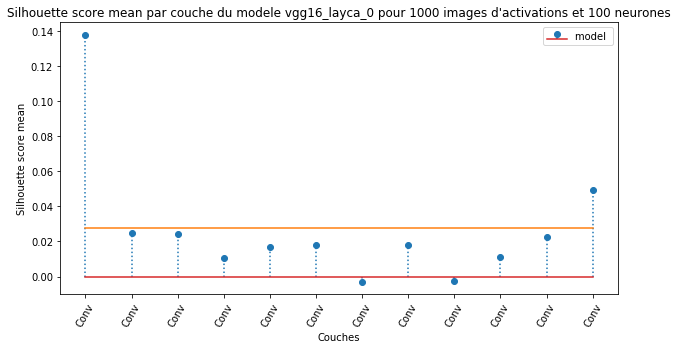

In [15]:
# plot:
fig = plt.figure(figsize=(10, 5))
#plt.ylim(top=0.1)
nombreCouches = len(Silhouette_Score_Mean)
x = range(nombreCouches)

markerline, stemlines, baseline = plt.stem(x, Silhouette_Score_Mean, markerfmt='o', label='model ')
plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
plt.setp(stemlines, 'linestyle', 'dotted')
plt.plot(np.mean(Silhouette_Score_Mean)*np.ones((nombreCouches,1)))

plt.legend()
plt.xlabel('Couches')
plt.xticks(np.arange(nombreCouches), ('Conv','Conv','Conv','Conv','Conv','Conv','Conv','Conv','Conv','Conv','Conv','Conv','Conv'), rotation=60)
plt.ylabel('Silhouette score mean')
plt.title('Silhouette score mean par couche du modele '+str(modelename)+' pour '+str(nombreDImagesDActivation)+' images d\'activations et '+str(NEURONS)+ ' neurones')
plt.show()
fig.savefig('figures/SilhouetteScoreMean_{}.png'.format(modelename), dpi=100)

## normalisation

In [65]:
#Layer to test
couche_name_1 = 'activation_1/Relu:0'
couche_name_2 = 'conv2d_2/BiasAdd:0'
couche_name_3 = 'activation_2/Relu:0'
#nombre de neurones dans la couche
numNeurons_1 = numpy.size(IM[couche_name_1][0])
print('number of neurons for the layer \''+couche_name_1+'\''+' : '+str(numNeurons_1))
numNeurons_2 = numpy.size(IM[couche_name_2][0])
print('number of neurons for the layer \''+couche_name_2+'\''+' : '+str(numNeurons_2))
numNeurons_3 = numpy.size(IM[couche_name_3][0])
print('number of neurons for the layer \''+couche_name_3+'\''+' : '+str(numNeurons_3))

number of neurons for the layer 'activation_1/Relu:0' : 65536
number of neurons for the layer 'conv2d_2/BiasAdd:0' : 65536
number of neurons for the layer 'activation_2/Relu:0' : 65536


In [68]:
NeuronsToTestIntoTheLayer = 100

#print(len(IM[couche_name_2][:,:,:,:])) # => 1000 activations
X_Kernel_size = len(IM[couche_name_2][0,:,:,:]) # => 32 x_coor
Y_Kernel_size = len(IM[couche_name_2][0,0,:,:]) # => 32 y_coor
Z_Kernel_size = len(IM[couche_name_2][0,0,0,:]) # => 64 couches

Weights = model.get_weights()

#print(len(Weights[0][0,0,0,:])) # couche convolutive n°1     3x3,  3 prof , 64 couches
#print(len(Weights[4][0,0,0,:])) # couche convolutive n°2     3x3, 64 prof , 64 couches

In [74]:

Silhouette_Score_Sum = 0

for i in range(NeuronsToTestIntoTheLayer):
    #Choix du neurone
    X = int(numpy.ceil(numpy.random.rand(1)*X_Kernel_size)-1)
    Y = int(numpy.ceil(numpy.random.rand(1)*Y_Kernel_size)-1)
    Z = int(numpy.ceil(numpy.random.rand(1)*Z_Kernel_size)-1)
    
    WeightsNeuron = np.asbolute(Weights[4][:,:,:,Z])
    WeightsRatio = np.mean(WeightsNeuron)/np.mean(Weights[4])
    #specification de ses bornes
    X_inf = X-1
    Y_inf = Y-1
    X_sup = X+1
    Y_sup = Y+1
    if X == 0: X_inf = 0
    if Y == 0: Y_inf = 0   
    if X == X_Kernel_size-1: X_sup = X_Kernel_size-1
    if Y == Y_Kernel_size-1: Y_sup = Y_Kernel_size-1
    
    Vecteurs_0 = [] #inactivé
    Vecteurs_1 = [] #activé
    for j in range(nombreDImagesDActivation):
        if IM[couche_name_3][j,X,Y,Z] == 0.0:
            Vecteurs_0.append(IM[couche_name_1][j,X_inf:X_sup,Y_inf:Y_sup,0:Z_Kernel_size].flatten())
        elif IM[couche_name_3][j,X,Y,Z] > 0.0:
            Vecteurs_1.append(IM[couche_name_1][j,X_inf:X_sup,Y_inf:Y_sup,0:Z_Kernel_size].flatten())
        else:
            print('error !')
            break
    #print(len(Vecteurs_0))
    #print(len(Vecteurs_1))
    S = SilhouetteScoreNormalized(Vecteurs_0,Vecteurs_1,WeightsRatio)
    if S != -2:        
        print('Neuron '+str(i+1)+'/'+str(NeuronsToTestIntoTheLayer)+' has a silhouette score of '+str(S))
        Silhouette_Score_Sum = Silhouette_Score_Sum + S
    else:
        NeuronsToTestIntoTheLayer = NeuronsToTestIntoTheLayer -1
    
    
Silhouette_Score_Mean = Silhouette_Score_Sum / NeuronsToTestIntoTheLayer
print('\n => The Silhouette score mean for the layer '+couche_name_2+' is : '+str(Silhouette_Score_Mean))

AttributeError: module 'numpy' has no attribute 'asb'